In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from help_functions.prepare_data import most_recent_thursday, split_time
from help_functions.calculate_score import evaluate_horizon
from help_functions.evaluate_energymodels import evaluate_energymodel, evaluate_different_energymodels

from energy_consumption.help_functions.get_energy_data import get_data
from energy_consumption.models.ec_model1 import get_ec_forecasts_model1

In [2]:
df = get_data()
start_date_excl = most_recent_thursday(df)
df_cval = df.loc[df.index < start_date_excl]

100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


In [3]:
# Functions work
model = {
    'name': 'model1',
    'function': get_ec_forecasts_model1
}
evaluation1 = evaluate_energymodel(model, df_cval, last_x=10,weeks=True)

models = [model]
evaluation2 = evaluate_different_energymodels(models,df_cval, last_x=10, weeks=True)

Iteration 2 of 10


C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumption\help_functions\dummy_mapping.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.loc[:, 'month'] = data_df.index.month


Iteration 3 of 10
Iteration 4 of 10
Iteration 5 of 10
Iteration 6 of 10
Iteration 7 of 10
Iteration 8 of 10
Iteration 9 of 10
*********** Start the evaluation of model model1***********
Iteration 2 of 10
Iteration 3 of 10
Iteration 4 of 10
Iteration 5 of 10
Iteration 6 of 10
Iteration 7 of 10
Iteration 8 of 10
Iteration 9 of 10


In [4]:
models

[{'name': 'model1',
  'function': <function energy_consumption.models.ec_model1.get_ec_forecasts_model1(energydata=None, indexes=[27, 31, 35, 51, 55, 59])>,
  'evaluation':                     forecast_date  target  horizon     q0.025      q0.25  \
  date_time                                                                  
  2023-11-03 03:00:00    2023-11-14  energy  36 hour  29.373000  30.744373   
  2023-11-03 07:00:00    2023-11-14  energy  40 hour  36.324500  43.323500   
  2023-11-03 11:00:00    2023-11-14  energy  44 hour  47.760000  52.535623   
  2023-11-04 03:00:00    2023-11-14  energy  60 hour  32.965007  31.585749   
  2023-11-04 07:00:00    2023-11-14  energy  64 hour  39.916507  44.164876   
  2023-11-04 11:00:00    2023-11-14  energy  68 hour  51.352007  53.376999   
  2023-10-27 03:00:00    2023-11-14  energy  36 hour  29.273990  30.502750   
  2023-10-27 07:00:00    2023-11-14  energy  40 hour  36.324500  42.174000   
  2023-10-27 11:00:00    2023-11-14  energy  44 h

### Visualize Comparison 

1. Create a table that only contains the different scores of the different models

In [5]:
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']
scores = []
names = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score']
                      [m['evaluation']['horizon'] == h])
        names.append(col_name)

score_df = pd.concat(scores, axis=1, keys=names)

2.  Plot the densities of the obtained scores

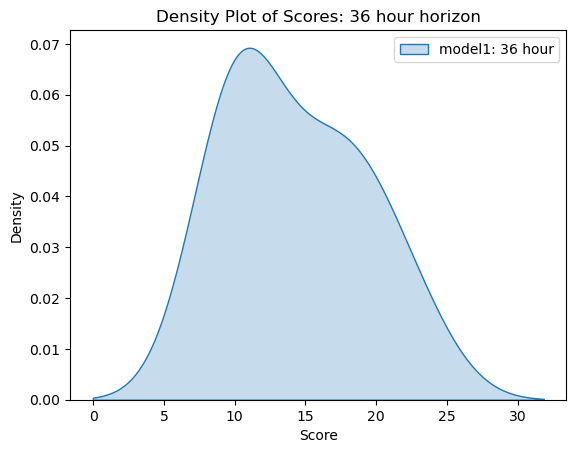

In [6]:
sns.kdeplot(data=score_df.loc[:, ['model1: 36 hour']], fill=True)

# Adding labels and title
plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Density Plot of Scores: 36 hour horizon')

# Display the plot
plt.show()

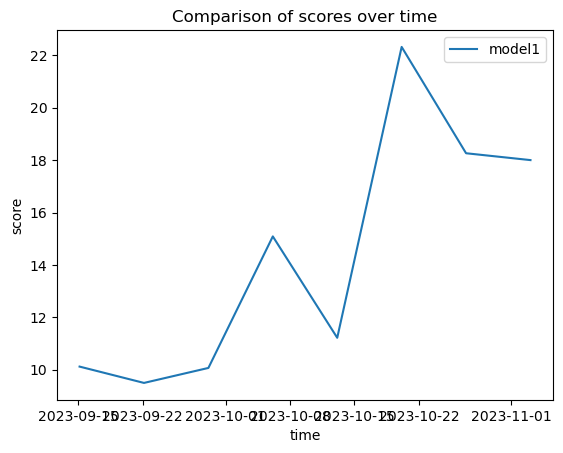

In [7]:
# Plot values from two columns over time
score_df_36_no_na = score_df[score_df['model1: 36 hour'].notna()]
# plt.plot(score_df_36_no_na.index, score_df_36_no_na['baseline: 36 hour'], label='baseline')
plt.plot(score_df_36_no_na.index,
         score_df_36_no_na['model1: 36 hour'], label='model1')

# Adding labels and title
plt.xlabel('time')
plt.ylabel('score')
plt.title('Comparison of scores over time')

# Display legend
plt.legend()

# Show the plot
plt.show()